# Natural Language Generation (NLG)

NLP comprises NLU (natural language understanding) plus NLG (natural language generation). Whereas NLU has been around for quite some time, NLG has recently made huge strides with the creation of ultra large models. The size of these models run into the trillions of parameters!

**NLG with Transformers**

https://huggingface.co/tftransformers/gpt2-large


- **Sanjiv**: I have adapted the notebook to run in our Colab accounts. You will need the file called `ascii_bible.txt` to run the notebook as well, placed in the `NLP_data` folder.

- For the leaderboard of the latest large language models, see: https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard. However, this is only the open LLMs and there are several closed LLMs from OpenAI, Cohere, AI21, Anthropic.  

- In this notebook we borrow code by [Max Woolf](http://minimaxir.com) to train a GPT-2 Text-Generating Model using `gpt-2-simple`. (See the license at the end of the notebook.)

## LICENSE

MIT License

Copyright (c) 2019 Max Woolf

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Recap of Transformers and LLMs

This is an excellent video that visualizes transformers and explains succinctly the inner workings of transformers and LLMs: https://www.youtube.com/watch?v=KJtZARuO3JY (by Grant Sanderson, [3Blue1Brown](https://www.3blue1brown.com)).

In [1]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Books_Writings/NLPBook/')

Mounted at /content/drive


In [2]:
%%capture
%pylab inline
import pandas as pd
import os
from IPython.display import Image

## gpt-2-simple

Here is the repository: https://github.com/minimaxir/gpt-2-simple

In [3]:
# %tensorflow_version 1.x
!pip install -q gpt-2-simple
import gpt_2_simple as gpt2
from datetime import datetime
from google.colab import files

  Preparing metadata (setup.py) ... done


## Check GPU

You can verify which GPU is active by running the cell below.

In [4]:
!nvidia-smi

Thu Feb 27 04:05:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Getting GPT-2

There are four sizes of GPT-2:

* `124M` (default): the "small" model, 500MB on disk.
* `355M`: the "medium" model, 1.5GB on disk.
* `774M`: the "large" model, cannot currently be finetuned with Colaboratory but can be used to generate text from the pretrained model (see later in Notebook)
* `1558M`: the "extra large", true model. Will not work if a K80/P4 GPU is attached to the notebook. (like `774M`, it cannot be finetuned).

Larger models have more knowledge, but take longer to finetune and longer to generate text. Specify which base model to use in the code block below.

The next cell downloads it from Google Cloud Storage and saves it in the Colaboratory VM at `/models/<model_name>`. This model isn't permanently saved in the Colaboratory VM; you'll have to redownload it if you want to retrain it at a later time.

We use the smallest GPT-2 model to do a quick implementation.

In [5]:
%%time
gpt2.download_gpt2(model_name="124M")

Fetching checkpoint: 1.05Mit [00:00, 4.48Git/s]                                                     
Fetching encoder.json: 1.05Mit [00:00, 2.55Mit/s]
Fetching hparams.json: 1.05Mit [00:00, 2.22Git/s]                                                   
Fetching model.ckpt.data-00000-of-00001: 498Mit [00:43, 11.4Mit/s]
Fetching model.ckpt.index: 1.05Mit [00:00, 3.36Git/s]                                               
Fetching model.ckpt.meta: 1.05Mit [00:00, 3.22Mit/s]
Fetching vocab.bpe: 1.05Mit [00:00, 3.46Mit/s]

CPU times: user 1.28 s, sys: 556 ms, total: 1.83 s
Wall time: 1min 2s


I have provided different examples of text on which to fine-tune below:

In [6]:
## EXAMPLE FILES
file_name = "NLP_data/ascii_bible.txt" # Generates biblical text
# file_name = "NLP_data/canterbury_tales_chaucer.txt" # Generates poetry like text
# file_name = "NLP_data/history_indian_philosophy.txt" # generates plain text

## Finetune GPT-2

The next cell will start the actual finetuning of GPT-2. It creates a persistent TensorFlow session which stores the training config, then runs the training for the specified number of `steps`. (to have the finetuning run indefinitely, set `steps = -1`)

The model checkpoints will be saved in `/checkpoint/run1` by default. The checkpoints are saved every 500 steps (can be changed) and when the cell is stopped.

The training might time out after 4ish hours; make sure you end training and save the results so you don't lose them!

**IMPORTANT NOTE:** If you want to rerun this cell, **restart the VM first** (Runtime -> Restart Runtime). You will need to rerun imports but not recopy files.

Other optional-but-helpful parameters for `gpt2.finetune`:


*  **`restore_from`**: Set to `fresh` to start training from the base GPT-2, or set to `latest` to restart training from an existing checkpoint.
* **`sample_every`**: Number of steps to print example output
* **`print_every`**: Number of steps to print training progress.
* **`learning_rate`**:  Learning rate for the training. (default `1e-4`, can lower to `1e-5` if you have <1MB input data)
*  **`run_name`**: subfolder within `checkpoint` to save the model. This is useful if you want to work with multiple models (will also need to specify  `run_name` when loading the model)
* **`overwrite`**: Set to `True` if you want to continue finetuning an existing model (w/ `restore_from='latest'`) without creating duplicate copies.

In [7]:
%%time
sess = gpt2.start_tf_sess()

gpt2.finetune(sess,
              dataset=file_name,
              model_name='124M',
              steps=150,
              restore_from='fresh',
              run_name='run1',
              print_every=10,
              sample_every=200,
              save_every=50,
              # reuse=True
              )

Loading checkpoint models/124M/model.ckpt
Loading dataset...


100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


dataset has 1564935 tokens
Training...
[10 | 26.05] loss=1.94 avg=1.94
[20 | 47.08] loss=2.02 avg=1.98
[30 | 68.42] loss=1.91 avg=1.96
[40 | 90.03] loss=1.98 avg=1.96
[50 | 111.90] loss=1.91 avg=1.95
Saving checkpoint/run1/model-50
[60 | 136.82] loss=1.83 avg=1.93
[70 | 159.45] loss=1.82 avg=1.91
[80 | 182.31] loss=2.03 avg=1.93
[90 | 205.16] loss=1.92 avg=1.93
[100 | 228.24] loss=1.84 avg=1.92
Saving checkpoint/run1/model-100


Instructions for updating:
Use standard file APIs to delete files with this prefix.


[110 | 256.33] loss=1.83 avg=1.91
[120 | 279.74] loss=1.81 avg=1.90
[130 | 303.29] loss=1.88 avg=1.90
[140 | 327.03] loss=1.74 avg=1.89
[150 | 350.85] loss=1.94 avg=1.89
Saving checkpoint/run1/model-150
CPU times: user 3min 44s, sys: 37.3 s, total: 4min 21s
Wall time: 6min 15s


## Save the model

After the model is trained, you can copy the checkpoint folder to your own Google Drive. (Look for a folder called `checkpoints`.)

If you want to download it to your personal computer, it's strongly recommended you copy it there first, then download from Google Drive. The checkpoint folder is copied as a `.rar` compressed file; you can download it and uncompress it locally.

In [8]:
%%time
gpt2.copy_checkpoint_to_gdrive(run_name='run1')

CPU times: user 259 ms, sys: 1.21 s, total: 1.47 s
Wall time: 23 s


You're done! Feel free to go to the **Generate Text From The Trained Model** section to generate text based on your retrained model.

## Load a Trained Model Checkpoint

Running the next cell will copy the `.rar` checkpoint file from your Google Drive into the Colaboratory VM.

In [9]:
gpt2.copy_checkpoint_from_gdrive(run_name='run1')

The next cell will allow you to load the retrained model checkpoint + metadata necessary to generate text.

**IMPORTANT NOTE:** If you want to rerun this cell, **restart the VM first** (Runtime -> Restart Runtime). You will need to rerun imports but not recopy files.

In [ ]:
# sess = gpt2.start_tf_sess()
# gpt2.load_gpt2(sess, run_name='run1')

## Generate Text From The Trained Model

After you've trained the model or loaded a retrained model from checkpoint, you can now generate text. `generate` generates a single text from the loaded model.

In [10]:
%%time
gpt2.generate(sess, run_name='run1')

        that is good in the sight of the LORD.

008:002 But he is an austere man in the sight of the LORD.

008:003 He is a man of unrighteousness, and a foolish man in heart.

008:004 But the LORD is merciful in his sight; and the wicked in his
        heart.

008:005 For the LORD make to the wicked an upright heart, so that he
        may know that he is in need.

008:006 He is an upright man in the sight of the LORD.

008:007 He is a man of ignorance, in the sight of the LORD; and a
        foolish man in heart.

008:008 He is a man of torments, even in the sight of the LORD.

008:009 He is a man of deceit, a rash man in the sight of the
        LORD; and a false prophet in the sight of the LORD.

008:010 The LORD shall be merciful to the wicked, and he shall
        be faithful to the righteous.

008:011 He will be an upright man in the sight of the LORD; and he
        shall know that he is in need.

008:012 He is a man of good knowledge, in the sight of the LORD; and he
        s

If you're creating an API based on your model and need to pass the generated text elsewhere, you can do `text = gpt2.generate(sess, return_as_list=True)[0]`

You can also pass in a `prefix` to the generate function to force the text to start with a given character sequence and generate text from there (good if you add an indicator when the text starts).

You can also generate multiple texts at a time by specifing `nsamples`. Unique to GPT-2, you can pass a `batch_size` to generate multiple samples in parallel, giving a massive speedup (in Colaboratory, set a maximum of 20 for `batch_size`).

Other optional-but-helpful parameters for `gpt2.generate` and friends:

*  **`length`**: Number of tokens to generate (default 1023, the maximum)
* **`temperature`**: The higher the temperature, the crazier the text (default 0.7, recommended to keep between 0.7 and 1.0)
* **`top_k`**: Limits the generated guesses to the top *k* guesses (default 0 which disables the behavior; if the generated output is super crazy, you may want to set `top_k=40`)
* **`top_p`**: Nucleus sampling: limits the generated guesses to a cumulative probability. (gets good results on a dataset with `top_p=0.9`)
* **`truncate`**: Truncates the input text until a given sequence, excluding that sequence (e.g. if `truncate='<|endoftext|>'`, the returned text will include everything before the first `<|endoftext|>`). It may be useful to combine this with a smaller `length` if the input texts are short.
*  **`include_prefix`**: If using `truncate` and `include_prefix=False`, the specified `prefix` will not be included in the returned text.

In [11]:
%%time
# Choose the prefix you want and then let it rip!
gpt2.generate(sess,
              length=250,
              temperature=0.7,
              prefix="Destiny is",
              nsamples=5,
              batch_size=5
              )

Destiny is the root of all nations.
        Thou shalt have light, and light shall not fail:

        and all nations shall come together in peace.

002:002 Also every tribe shall have dominion over the poor, and
        shall reign over the needy.

002:003 This is the end of all of the kingdoms which have been
        broken up.

002:004 The Jews shall rule over the few: they shall be
        rulers over all nations, and over all nations will be
        the gates of the world.

002:005 The sons of the LORD shall be as the handmaids of the
        children of Israel, which shall inhabit the earth, and shall
        serve the princes of the children of Israel.

002:006 Because of the faith of the LORD, and the great work of
        the LORD, how is it that the children of Israel the LORD
    
Destiny is for us a record, as a city;
        the same also is for us as a wall: for we are a house of the
        inhabitants of the Gentiles.

024:008 And the same is for us as a house of the Je

But, will AI truly learn to write well? Probably. Look at this letter written by John Steinbeck, and ask, can an AI write in this way?

In 2022, we have seen AIs write incredibly well informed text. Models such as Google's LaMDA (https://blog.google/technology/ai/lamda/) are astonighingly literate. The paper is here: https://arxiv.org/abs/2201.08239

Take a look at how well it performs using the interface from https://beta.character.ai.



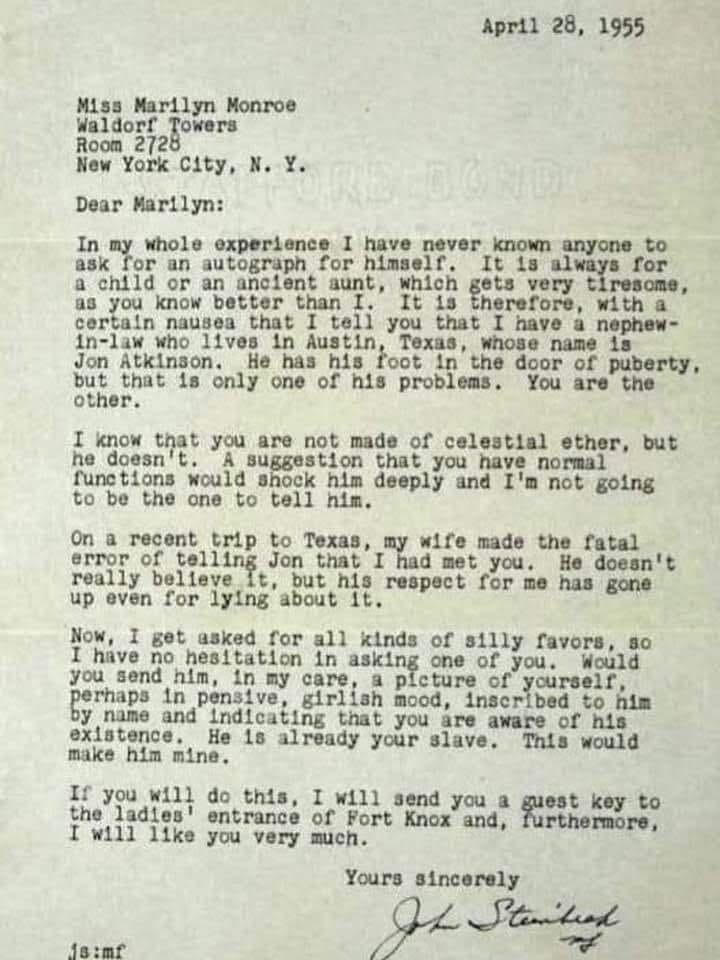

In [ ]:
Image("NLP_images/steinbeck_monroe.jpg", width=600)

## Large Language Models

- Training large language models (LLMs) is extremely expensive. Generative models such as GPT-3 (https://en.wikipedia.org/wiki/GPT-3) is estimated to have cost $12M.

- The pre-training dataset for LaMDA consists of 2.97B documents, 1.12B dialogs, and 13.39B dialog utterances, for a total of 1.56T words. Pre-trained on 1024 TPU-v3 chips for a total of about 57.7 days, and 256K tokens per batch. Approximately equivalent to 22 passengers taking a round trip between San Francisco and New York (1.2 tCO2e / passenger).

- BLOOM (176B parameters) is another large language model: https://bigscience.huggingface.co/blog/bloom. As stated by the site: "*With its 176 billion parameters, BLOOM is able to generate text in 46 natural languages and 13 programming languages. For almost all of them, such as Spanish, French and Arabic, BLOOM will be the first language model with over 100B parameters ever created. This is the culmination of a year of work involving over 1000 researchers from 70+ countries and 250+ institutions, leading to a final run of 117 days (March 11 - July 6) training the BLOOM model on the Jean Zay supercomputer in the south of Paris, France thanks to a compute grant worth an estimated €3M from French research agencies CNRS and GENCI.*" BLOOM is an example of open LLM modeling, in contrast to other models that are built by large tech companies.

- BLOOM also advocates Responsible AI via its new license, RAIL: https://bigscience.huggingface.co/blog/the-bigscience-rail-license. This connects to the discussion of ML Explainability, one aspect of Responsible AI.

- Stable Diffusion deploys open source text to image models: https://stability.ai/blog/stable-diffusion-public-release

- Deployed in SageMaker: https://aws.amazon.com/about-aws/whats-new/2022/11/sagemaker-jumpstart-stable-diffusion-bloom-models/

- A collection of links to LLMs on Github: https://gist.github.com/rain-1/eebd5e5eb2784feecf450324e3341c8d

- Five Years of GPTs: https://finbarr.ca/five-years-of-gpt-progress/


## Using BLOOM

This is an excellent source for example code: https://amazon.awsapps.com/workdocs/index.html#/document/0beeca78eaca3b53f2a3beb37b3d515848ccb8965c9241c846bf44b37b21203a

## Building LLMs from scratch

This is a nice 3-hour presentation by Sebastian Raschka, if you want to dive into a better understanding of LLMs. See the substack post: https://magazine.sebastianraschka.com/p/building-llms-from-the-ground-up

https://www.youtube.com/watch?v=quh7z1q7-uc